# Data Structure

In [ ]:
# DATASET/
#     HEALTHY PLANT/
#         APPLE/
#             apple01.jpg
#             apple02.jpg
#             ...
#         BLUBERRY/
#             bluberry01.jpg
#             bluberry02.jpg
#             ...
#         ...
#     JENIS TANAH/
#         ALUVIAL/
#             aluvial_1.jpg
#             aluvial_2.jpg
#             ...
#         CHERNOZEM/
#             chernozem_1.jpg
#             chernozem_2.jpg
#             ...
#         ...
#     PENYAKIT/
#         BACTERIAL_SPOT/
#             bacterial_spot01.jpg
#             bacterial_spot02.jpg
#             ...
#         BLACK_MEASLES/
#             black_measles01.jpg
#             black_measles02.jpg
#             ...
#         ...


# Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install PyDrive

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autentikasi pengguna
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
file_id = '1GIuB_hYs37TOecpzSdmVPOMAHkmnmNUb'  # Ganti dengan ID file yang diberikan oleh teman Anda
downloaded_file = drive.CreateFile({'id': file_id})
downloaded_file.GetContentFile('/content/DATASET.zip')  # Simpan file di Colab sementara

In [6]:
import zipfile

with zipfile.ZipFile('/content/DATASET.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset_Floravista')  # Ekstrak isi ZIP ke folder

# Library

In [7]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
# import tensorflow as tf
import matplotlib
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [1]:
!pip install tensorflow==2.15.0

import tensorflow as tf
print(tf.__version__)


2.15.0


# Split data healthy plant

In [8]:
def create_train_test_val_dirs(root_dir, categories):
    for category in categories:
        train_dir = os.path.join(root_dir, 'train', category)
        test_dir = os.path.join(root_dir, 'test', category)
        val_dir = os.path.join(root_dir, 'validation', category)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        print(f"Created directories: {train_dir}, {test_dir}, {val_dir}")

def split_data(SOURCE, TRAINING, TEST, VALIDATION, train_split, test_split):
    all_files = os.listdir(SOURCE)
    np.random.shuffle(all_files)
    train_size = int(len(all_files) * train_split)
    test_size = int(len(all_files) * test_split)
    val_size = len(all_files) - train_size - test_size

    train_files = all_files[:train_size]
    test_files = all_files[train_size:train_size + test_size]
    val_files = all_files[train_size + test_size:]

    print(f"Splitting {len(all_files)} files into {len(train_files)} train, {len(test_files)} test and {len(val_files)} validation")

    for file in train_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(TRAINING, file))
        print(f"Copied {file} to {TRAINING}")

    for file in test_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(TEST, file))
        print(f"Copied {file} to {TEST}")

    for file in val_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(VALIDATION, file))
        print(f"Copied {file} to {VALIDATION}")

# Define directories
root_dir = 'Dataset_Floravista/FLORA VISTA/HEALTHY PLANT'
categories = ['APPLE', 'BLUEBERRY', 'CHERRY', 'CORN', 'GRAPE', 'PEACH', 'PEPPER',
              'POTATO', 'RASPBERRY', 'SOYBEAN', 'STRAWBERRY', 'TOMATO']  # Daftar kategori tanaman sehat

# Create train, test and validation directories
create_train_test_val_dirs(root_dir, categories)

# Split data
train_split = 0.7  # 70% training
test_split = 0.2   # 20% testing
for category in categories:
    source_dir = os.path.join(root_dir, category)
    training_dir = os.path.join(root_dir, 'train', category)
    test_dir = os.path.join(root_dir, 'test', category)
    validation_dir = os.path.join(root_dir, 'validation', category)

    if not os.path.exists(source_dir):
        print(f"Source directory does not exist: {source_dir}")
        continue

    split_data(source_dir, training_dir, test_dir, validation_dir, train_split, test_split)


Created directories: Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/train/APPLE, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/test/APPLE, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/validation/APPLE
Created directories: Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/train/BLUEBERRY, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/test/BLUEBERRY, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/validation/BLUEBERRY
Created directories: Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/train/CHERRY, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/test/CHERRY, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/validation/CHERRY
Created directories: Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/train/CORN, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/test/CORN, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/validation/CORN
Created directories: Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/train/GRAPE, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/test/GRAPE, Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/validation/GRAP

In [9]:
# path healthy plant
train_path_healthy = 'Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/train'
val_path_healthy = 'Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/validation'
test_path_healthy = 'Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/test'

# Data augmentation for healthy and disease plant

In [10]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan untuk tanaman
train_datagen_healthy = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Membuat objek ImageDataGenerator untuk rescaling pada set validasi dan test untuk tanaman
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat dan augmentasi data untuk tanaman sehat
train_generator_healthy = train_datagen_healthy.flow_from_directory(
    train_path_healthy,
    target_size=(224, 224),  # Menentukan ukuran gambar yang diharapkan
    batch_size=32,
    class_mode='categorical'
)

validation_generator_healthy = val_test_datagen.flow_from_directory(
    val_path_healthy,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator_healthy = val_test_datagen.flow_from_directory(
    test_path_healthy,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1800 images belonging to 12 classes.
Found 861 images belonging to 12 classes.
Found 1336 images belonging to 12 classes.


# Memuat dataset validasi healthy

In [11]:
# Memuat dataset validasi
X_validation_healthy = []
y_validation_healthy = []

validation_dir = "Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/validation"

# Mendefinisikan kategori tanaman dan penyakit
categories = ['APPLE', 'BLUEBERRY', 'CHERRY', 'CORN', 'GRAPE', 'PEACH', 'PEPPER',
              'POTATO', 'RASPBERRY', 'SOYBEAN', 'STRAWBERRY', 'TOMATO']

for i, category in enumerate(categories):
    folder = os.path.join(validation_dir, category)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(folder, file)

        image = cv2.imread(image_path)  # Membaca gambar
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengonversi format warna dari BGR ke RGB
        image = cv2.resize(image, (224, 224))  # Mengubah ukuran gambar menjadi (224, 224)
        image = image / 255.0  # Normalisasi nilai piksel ke dalam rentang 0-1
        X_validation_healthy.append(image)
        y_validation_healthy.append(i)  # Menambahkan label kategori

X_validation_healthy = np.array(X_validation_healthy)
y_validation_healthy = np.array(y_validation_healthy)

# Memuat dataset pengujian
X_test_healthy = []
y_test_healthy = []

test_dir = "Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/test"

for i, category in enumerate(categories):
    folder = os.path.join(test_dir, category)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(folder, file)

        image = cv2.imread(image_path)  # Membaca gambar
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengonversi format warna dari BGR ke RGB
        image = cv2.resize(image, (224, 224))  # Mengubah ukuran gambar menjadi (224, 224)
        image = image / 255.0  # Normalisasi nilai piksel ke dalam rentang 0-1
        X_test_healthy.append(image)
        y_test_healthy.append(i)  # Menambahkan label kategori

X_test_healthy = np.array(X_test_healthy)
y_test_healthy = np.array(y_test_healthy)

# Menampilkan bentuk dari masing-masing dataset
print("Bentuk array dari dataset validation (validasi) tanaman adalah:", X_validation_healthy.shape, y_validation_healthy.shape)
print("Bentuk array dari dataset test (pengujian) tanaman adalah:", X_test_healthy.shape, y_test_healthy.shape)


Bentuk array dari dataset validation (validasi) tanaman adalah: (861, 224, 224, 3) (861,)
Bentuk array dari dataset test (pengujian) tanaman adalah: (1336, 224, 224, 3) (1336,)


# Membuat kamus label dan mencetak label

In [12]:
# Membuat kamus label untuk tanaman sehat
label_dict_healthy = train_generator_healthy.class_indices

# Menggabungkan kamus label dari kedua kategori
label_dict = {}
label_dict.update(label_dict_healthy)

# Mencetak nama kategori (tanaman sehat dan penyakit) berdasarkan label angka
for label, idx in label_dict.items():
    print(f"index {idx}: {label}")

index 0: APPLE
index 1: BLUEBERRY
index 2: CHERRY
index 3: CORN
index 4: GRAPE
index 5: PEACH
index 6: PEPPER
index 7: POTATO
index 8: RASPBERRY
index 9: SOYBEAN
index 10: STRAWBERRY
index 11: TOMATO


# Menyimpan label

In [13]:
print(train_generator_healthy.class_indices)

labels_txt_healthy = '\n'.join(sorted(train_generator_healthy.class_indices.keys()))

# Simpan label tanaman sehat ke dalam file labels_healthy.txt
with open('labels_healthy.txt', 'w') as f:
    f.write(labels_txt_healthy)


{'APPLE': 0, 'BLUEBERRY': 1, 'CHERRY': 2, 'CORN': 3, 'GRAPE': 4, 'PEACH': 5, 'PEPPER': 6, 'POTATO': 7, 'RASPBERRY': 8, 'SOYBEAN': 9, 'STRAWBERRY': 10, 'TOMATO': 11}


# Transfer learning

In [14]:
from tensorflow.keras.applications import MobileNetV2

IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

In [15]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

# Build CNN healthy

In [16]:
from tensorflow.keras.utils import to_categorical

# Mengonversi label menjadi one-hot encoding
y_test_healthy_encoded = to_categorical(y_test_healthy)

# Menetapkan ulang variabel X_test_healthy dan y_test_healthy_encoded
X_test_healthy_final, y_test_healthy_final = X_test_healthy, y_test_healthy_encoded


# Add custom layer healthy

In [17]:
# Jumlah kelas untuk tanaman sehat
num_classes_healthy = 12

# Membuat model dengan MobileNetV2 sebagai base model
model_healthy = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes_healthy, activation='softmax')  # Mengubah jumlah unit ke 12
])

# Kompilasi model
model_healthy.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Menampilkan ringkasan model
model_healthy.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 2627052 (10.02 MB)
Trainable params: 36906

In [18]:
history = model_healthy.fit(train_generator_healthy,
                    epochs=10,
                    validation_data=validation_generator_healthy)

Epoch 1/10
57/57 [==============================] - 34s 469ms/step - loss: 1.0163 - accuracy: 0.6828 - val_loss: 0.2667 - val_accuracy: 0.9222
Epoch 2/10
57/57 [==============================] - 23s 408ms/step - loss: 0.3530 - accuracy: 0.8900 - val_loss: 0.1965 - val_accuracy: 0.9454
Epoch 3/10
57/57 [==============================] - 26s 448ms/step - loss: 0.2871 - accuracy: 0.9039 - val_loss: 0.1568 - val_accuracy: 0.9512
Epoch 4/10
57/57 [==============================] - 26s 455ms/step - loss: 0.1896 - accuracy: 0.9417 - val_loss: 0.1210 - val_accuracy: 0.9640
Epoch 5/10
57/57 [==============================] - 27s 481ms/step - loss: 0.2002 - accuracy: 0.9433 - val_loss: 0.0850 - val_accuracy: 0.9721
Epoch 6/10
57/57 [==============================] - 25s 445ms/step - loss: 0.1467 - accuracy: 0.9583 - val_loss: 0.1030 - val_accuracy: 0.9686
Epoch 7/10
57/57 [==============================] - 26s 450ms/step - loss: 0.1594 - accuracy: 0.9528 - val_loss: 0.1503 - val_accuracy: 0.9408

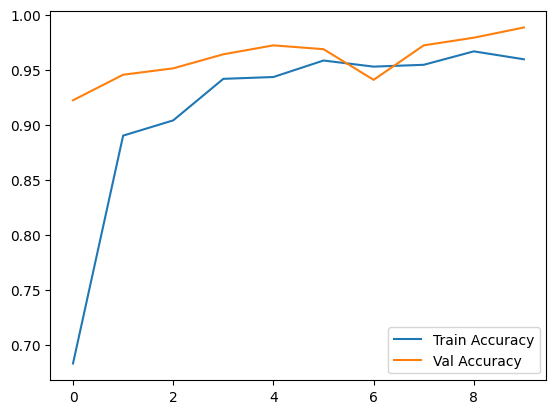

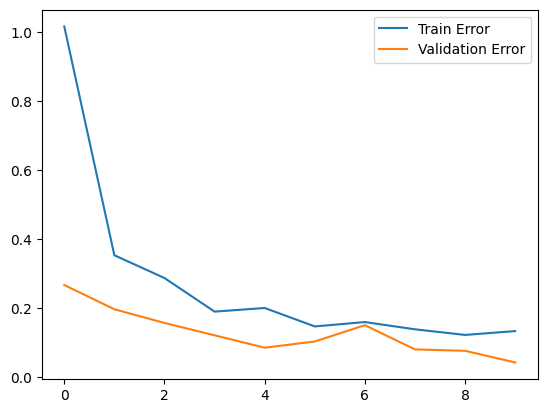

In [19]:
plt.plot(history.history["accuracy"],label="Train Accuracy")
plt.plot(history.history["val_accuracy"],label="Val Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Train Error")
plt.plot(history.history["val_loss"],label="Validation Error")
plt.legend()
plt.show()

In [21]:
# tfjs

!pip install tensorflowjs

  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [21]:
# save model h5
model_healthy.save("model_plant_classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!ls -l model_plant_classification.h5

-rw-r--r-- 1 root root 13817272 Jun 14 14:07 model_plant_classification.h5


In [ ]:
#convert to tfjs

!tensorflowjs_converter --input_format=keras model_plant_classification.h5 /tfjs_model

2024-06-14 14:09:40.222878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


In [20]:
import numpy as np
from keras.models import model_from_json

# Simpan arsitektur model ke dalam file JSON
model_json = model_healthy.to_json()
with open("model_plant_classification.json", "w") as json_file:
    json_file.write(model_json)

# Simpan bobot model ke dalam file biner
weights = model_healthy.get_weights()
with open("model_plant_classification.bin", "wb") as bin_file:
    for weight in weights:
        np.save(bin_file, weight)

print("Model dan bobot telah disimpan ke dalam file JSON dan BIN.")

Model dan bobot telah disimpan ke dalam file JSON dan BIN.


In [ ]:
# # Muat arsitektur model dari file JSON
# with open("model_plant_classification.json", "r") as json_file:
#     loaded_model_json = json_file.read()

# loaded_model = model_from_json(loaded_model_json)

# # Simpan bobot model dalam format HDF5
# model_healthy.save_weights("model_plant_classification_weights.h5")

In [22]:
import tensorflow as tf

# Load model keras
model = tf.keras.models.load_model('save_model/model_plant_classification.h5')

# Konversi model keras ke model TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke dalam file
with open('model_plant_classification.tflite', 'wb') as f:
    f.write(tflite_model)

OSError: No file or directory found at save_model/model_plant_classification.h5

# Prediksi gambar

1/1 [==============================] - 2s 2s/step
Predicted class: GRAPE
Confidence: 0.9884466


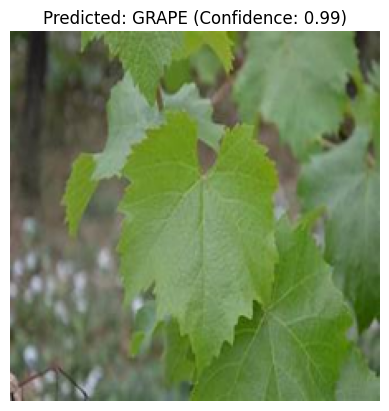

In [23]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi untuk mengunduh dan praproses gambar
def preprocess_image_from_url(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)  # Ubah ukuran gambar
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalisasi sesuai dengan MobileNetV2
    return img, img_array

# URL gambar yang ingin diuji
image_url = " https://tse4.mm.bing.net/th?id=OIP.6y0gSMQJZC3RMOrNNXkoUgHaE8&pid=Api&P=0&h=220 "

# Prakiraan dan praproses gambar
original_img, processed_img = preprocess_image_from_url(image_url, target_size=(224, 224))

# Lakukan prediksi
prediction = model_healthy.predict(processed_img)

# Interpretasi hasil prediksi
predicted_class_index = np.argmax(prediction)
confidence = prediction[0][predicted_class_index]

# Membuat kamus label
label_dict = train_generator_healthy.class_indices
index_to_label = {v: k for k, v in label_dict.items()}

# Print hasil
predicted_label = index_to_label[predicted_class_index]
print("Predicted class:", predicted_label)
print("Confidence:", confidence)

# Tampilkan gambar beserta prediksi
plt.imshow(original_img)
plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()


In [24]:
# Memilih indeks gambar yang ingin diprediksi
n = 3

# Memuat gambar dari dataset validasi
input_image_path = '/content/Dataset_Floravista/FLORA VISTA/HEALTHY PLANT/SOYBEAN/SOYBEAN_-0348-406e-a409-6a578ad8c604___RS_HL 3414.jpg'  # Ganti dengan path gambar yang ingin diprediksi
input_image = cv2.imread(input_image_path)  # Membaca gambar
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Mengubah format warna BGR ke RGB
input_image = cv2.resize(input_image, (224, 224))  # Mengubah ukuran gambar
input_image = input_image / 255.0  # Normalisasi nilai piksel

# Menambahkan dimensi batch pada gambar
input_image = input_image[np.newaxis, ...]

# Melakukan prediksi menggunakan model
predictions = model_healthy.predict(input_image)

# Mendapatkan label sebenarnya
true_label = "SOYBEAN"  # Ganti dengan label sebenarnya yang sesuai dengan gambar yang diprediksi

# Mencetak label sebenarnya dan hasil prediksi
print("Label sebenarnya:", true_label)
print("Prediksi model:", predictions)


1/1 [==============================] - 0s 24ms/step
Label sebenarnya: SOYBEAN
Prediksi model: [[2.9857489e-07 4.9462047e-04 3.1056647e-05 1.5907730e-08 1.4932994e-07
  1.9638703e-06 1.3327538e-03 1.4662746e-02 1.3365765e-08 9.8309118e-01
  2.1078659e-08 3.8514833e-04]]


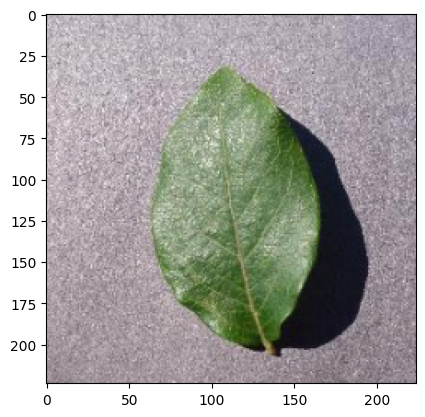

Label yang benar adalah: 1
1/1 [==============================] - 0s 22ms/step
Nilai yang diprediksi adalah: [4.9977372e-10 9.9991107e-01 3.1958094e-09 3.4637903e-08 2.6079017e-12
 1.5150201e-08 8.8292087e-05 6.3293508e-09 6.9314068e-11 5.5014431e-07
 1.1455744e-09 2.9912695e-08]
Label yang diprediksi adalah: 1 : BLUEBERRY
Prediksi benar


In [25]:
n = 157  # Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test_healthy[n])
plt.show()

# Label yang benar
true_label = y_test_healthy[n]
print("Label yang benar adalah:", true_label)

# Prediksi model
prediction = model_healthy.predict(X_test_healthy[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:", prediction)

# Label yang diprediksi
predicted_label = np.argmax(prediction)
predicted_class = list(label_dict.keys())[predicted_label]
print("Label yang diprediksi adalah:", predicted_label, ":", predicted_class)

# Memeriksa apakah prediksi benar
if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")


42/42 [==============================] - 3s 69ms/step


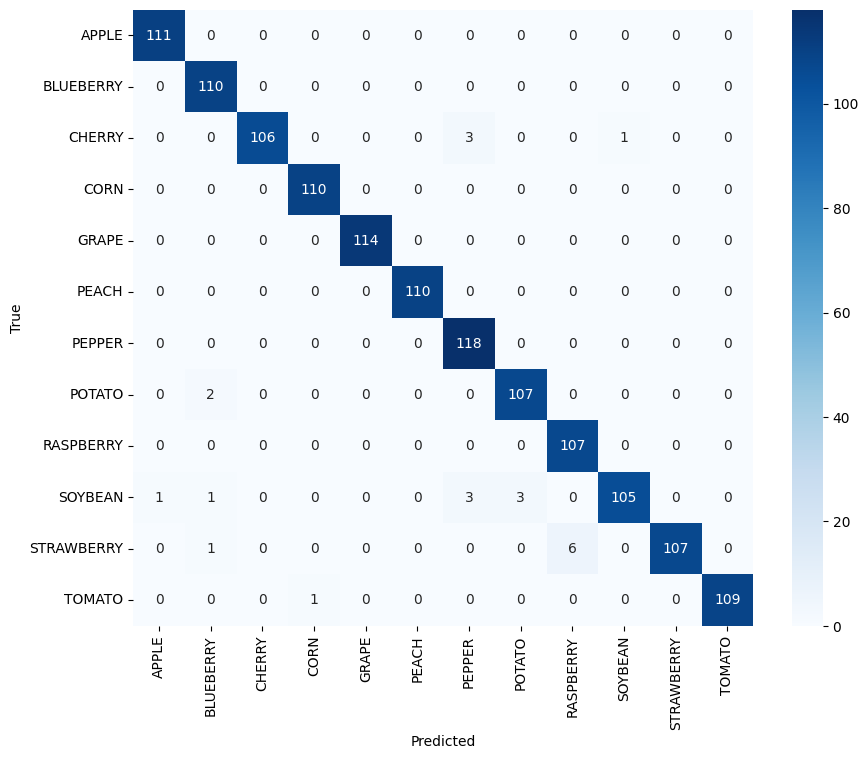

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_healthy.predict(X_test_healthy)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_healthy, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
